<a href="https://colab.research.google.com/github/podyssea/InformationRetrieval/blob/main/InformationRetrievalExercise2_2210049p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval Exercise 2 Notebook 


This is the template notebook for Exercise 2. The specification for the exercise and the corresponding Exercise 2 submission instance are available on the Moodle page of the course.

This exercise builds upon Exercise 1, and assumes you are now familiar with concepts we have introduced in both the introductory lab and Exercise 1, including:
 - [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - [Pyterrier apply transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 - [PyTerrier pt.Experiment()](https://pyterrier.readthedocs.io/en/latest/experiments.html)


## PyTerrier Setup

Firt, we need to install PyTerrier. If you have been using your own machine, you will need to upgrade PyTerrier to the latest version for running this Exercise 2 notebook.

In [3]:
!date
!pip install python-terrier


Thu Mar  4 06:43:52 UTC 2021
     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.1MB 7.0MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 2.8MB 12.6MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 163kB 27.6MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 1.8MB 47.7MB/s 
     |████████████████████████████████| 5.5MB 41.1MB/s 
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.4.0-cp37-none-any.whl size=76208 sha256=282a47b081082cdc3e90348d9d9d44fbf9ec09149fb29d6e9e4e6eaddc4db44b
  Stored in directory: /root/.cache/pip/wheels/1a/08/00/1eb79fd13e6095132bf00bd92f803e90797

Start PyTerrier; This time we are specifying `tqdm='notebook'` to get pretty progress bars during retrieval. 

In [4]:
import pyterrier as pt
if not pt.started():
  pt.init(tqdm='notebook')

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


terrier-assemblies 5.4  jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.5  jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.4.0 has loaded Terrier 5.4 (built by craigm on 2021-01-16 14:17)


## Index, Topics & Qrels for Exercise 2

You will need your login & password credentials from Exercise 1. We will be using again the "50pct" and the "trec-wt-2004" datasets from Exercise 1.


In [5]:
UNAME="TODO"
PWORD="TODO"

from pyterrier.datasets import STANDARD_TERRIER_INDEX_FILES, RemoteDataset

# we will again be using the "50pct" and "trec-wt-2004" datasets
Fiftypct =  pt.get_dataset("50pct",  user="2210049p", password="e54de6e4")
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

On the other hand, you will be using a slightly updated index for Exercise 2. It is a bit bigger than the Exercise 1 index, hence it takes about 2-3 minutes to download to Colab.

In [6]:
!date
indexref = Fiftypct.get_index(variant="ex2")
index = pt.IndexFactory.of(indexref)
!date

Thu Mar  4 06:44:32 UTC 2021



06:47:09.088 [main] WARN  o.t.structures.CompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 860.9 MiB of memory would be required.
Thu Mar  4 06:47:09 UTC 2021


Let's check out the new index. Compared to the index we used for Exercise 1, you can see that this index has `Field Names: [TITLE, ELSE]`, which means that we can provide statistics about how many times each term occurs in the title of each document (the "TITLE" field), vs the rest of the document (the "ELSE" field). Refer to Lecture 8 for more information about fields.

Let's also display the keys in the meta index - this is the metadata that we have stored for each document. You can see that we are storing the "url" and the "body" (content) of the document. These will particularly come in handy for Q2 and Q3 of Exercise 2, respectively.


In [7]:
print(index.getCollectionStatistics().toString())
print("In the meta index: " + str(index.getMetaIndex().getKeys()))

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 2
Number of tokens: 572916194
Field names: [TITLE, ELSE]
Positions:   true

In the meta index: ['docno', 'url', 'title', 'body']


Finally, these are all of the topics and qrels (including the training and validation datasets) that you will need to conduct Exercise 2.

In [8]:
tr_topics = Fiftypct.get_topics("training")
va_topics = Fiftypct.get_topics("validation")

tr_qrels = Fiftypct.get_qrels("training")
va_qrels = Fiftypct.get_qrels("validation")

test_topics = dotgov_topicsqrels.get_topics("hp")
test_qrels = dotgov_topicsqrels.get_qrels("hp")

## Baseline Setup

We introduce here the BatchRetrieve for our baseline. Note that:
 - We are using PL2 as our weighting model to generate the sample (the candidate set of documents to re-rank).
 - We expose more document metadata, namely "url" and "body" for each document retrieved, which you will need to deploy your two new features. 
 - By setting `verbose=True`, we display a progress bar while retrieval executes.

In [9]:
firstpassUB = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)

Let's see the resulting output - you can see that there are now "url" and "body" attributed for each retrieved document. (We also display a progress bar, enabled by the `verbose=True`).

In [10]:
firstpassUB.search("chemical reactions")

,qid,docid,docno,url,body,rank,score,query
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. ...,1,11.906524,chemical reactions
2,1,707122,G26-06-3754605,http://www.aps.anl.gov/xfd/tech/safetyenvelope...,APS Experiment Safety Envelope 6: Chemicals ...,2,11.877550,chemical reactions
3,1,382754,G13-59-3981168,http://response.restoration.noaa.gov/chemaids/...,"""); } else { document.write(...",3,11.858475,chemical reactions
4,1,70292,G02-16-2617043,http://www.symp14.nist.gov/PDF/COR04MAY.PDF,A Database of Chemical Reactions Designed to A...,4,11.731490,chemical reactions
...,...,...,...,...,...,...,...,...
995,1,246965,G08-68-4141101,http://en-env.llnl.gov/asd/pinatub.html,The Chemical and Radiative Effects of the Moun...,995,6.290707,chemical reactions
996,1,611136,G22-04-3955177,http://eospso.gsfc.nasa.gov/ftp_docs/Ch7.pdf,Chapter 7 ...,996,6.289822,chemical reactions
997,1,594957,G21-38-0191596,http://www.oit.doe.gov/news/oittimes/wn02/wn02...,search ...,997,6.287830,chemical reactions
998,1,280944,G09-85-3411646,http://www.ig.doe.gov/pdf/chemfina.pdf,INS-O-00-01 I N S P E C T I O N ...,998,6.287759,chemical reactions


# Standard list of features

Let's introduce the list of features we need to deploy a baseline learning-to-rank approach.

In [11]:
pagerankfile = indexref.toString().replace(".properties", "-pagerank.oos")
features = [
    "SAMPLE", #ie PL2
    "WMODEL:SingleFieldModel(BM25,0)",
    "QI:StaticFeature(OIS,%s)" % pagerankfile,
]

stdfeatures = pt.FeaturesBatchRetrieve(index, features, verbose=True)
stage12 = firstpassUB >> stdfeatures

This is our feature set. We will be using FeaturesBatchRetrieve to compute these extra features on the fly. Let's see the output. You can see that there is now a "features" column.

In [12]:
stage12.search("chemical reactions").head(2)

,qid,query,docid,rank,features,docno,score
0,1,chemical reactions,513586,0,"[12.755545561073266, 3.0924078763629836, 0.000...",G18-38-1767991,12.755546
1,1,chemical reactions,38544,1,"[11.90652405775751, 10.789390732195702, 0.0002...",G01-14-2537005,11.906524


Let's look in more detail at the features. It is clear that there are 3 numbers for each document. The first is the PL2 score (1.27555456e+01 == 12.7555), the second is the BM25 score, and the third is the PageRank (a link analysis feature - discussed in more detail in Lecture 10)

In [13]:
stage12.search("chemical reactions").head(1).iloc[0]["features"]

array([1.27555456e+01, 3.09240788e+00, 1.05668333e-04])

# Q1

You now have everyting you need to attempt Q1. You will need to refer to the specification, and to PyTerrier's [learning to rank documentation](https://pyterrier.readthedocs.io/en/latest/ltr.html).

You should use a LightGBM LambdaMART implementation (not XGBoost), instantiated using the configuration suggested in the PyTerrier documentation.

Hints:
 - You will need to use the provided separate “training” and “validation” topic sets and qrels to train the learning-to-rank.
 - There is no need to vary the configuration of LightGBM from that in the documentation.

In [14]:
import lightgbm as lgb
lmart_l = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

lmart_l_pipe = stage12 >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
lmart_l_pipe.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe], test_topics, test_qrels, ["map", "P.5"], names=["PL2 Baseline", "LTR (PL2 Sample)"], baseline = 0)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.351852
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.407407
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.388889
[10]	valid_0's ndcg@1: 0.388889


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2 Baseline,0.225110,0.069333,NaN,NaN,NaN,NaN,NaN,NaN
1,LTR (PL2 Sample),0.410703,0.114667,45.0,15.0,0.000097,22.0,6.0,0.001787


#Q2 - URL Length Features

In this block, please provide your code for Q2 concerning the URL length feature(s). There are different possible URL length features that you could implement (see specification) - you might try more than one implementation, and choose the one that is the most effective.

Some hints:

 - You will need to use a [pt.apply function](https://pyterrier.readthedocs.io/en/latest/apply.html) for computing your URL length feature(s). The dataframe of results obtained from the upstream transformer has all of the information you need.

 - You can use a `**` operator for combining feature sets.

 - Refer to the PyTerrier learning to rank documentation  concerning `features_importances_` for obtaining feature importances, as required in Q2(c).

 - You may wish to refer to Python's [`urlparse()`](https://docs.python.org/3/library/urllib.parse.html) function.

 - Use Python assertions to test that your feature implmentation(s) give the expected results. This is needed for Q2(b).


In [15]:
import numpy as np
from urllib.parse import urlparse

def _url_length_feature(row):
    #Get the docid
    docid = row["docid"]
    #Get the content of the url string
    content = index.getMetaIndex().getItem("url", docid)
    #Get the length of the url
    f1 = len(content)
    return np.array([f1])

def _url_slashes_feature(row):
    #Get the docid
    docid = row["docid"]
    #Get the content of the url string
    content = index.getMetaIndex().getItem("url", docid)
    #Get the number of "/" in the url
    f1 = content.count("/")
    return np.array([f1])

def _url_chars_after_hostname_feature(row):
    docid = row["docid"]
    #Get the content of the url string
    content = index.getMetaIndex().getItem("url", docid)
    return np.array([len("".join(content.split("/")[2:]))])

def _url_category_feature(row):
    docid = row["docid"]
    #Get the content of the url string
    content = index.getMetaIndex().getItem("url", docid)
    s = content.split("/")[2:]
    if (len(s) == 2 and re.search(".html$", s[1])) or len(s) ==1:
      return np.array([1])
    elif len(s) == 3 and re.search(".html$", s[2]):
      return np.array([2])
    elif re.search(".html$", s[-1]):
      return np.array([3])
    else:
      return np.array([4])

In [16]:
lmart_l_url_slashes = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

secondpassUB_slashes = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
url_slashes_feature = secondpassUB_slashes >> pt.apply.doc_features(_url_slashes_feature)
combined_features_url_slashes = secondpassUB_slashes >> (stage12 ** url_slashes_feature)
boosted_model_url_slashes = combined_features_url_slashes >> pt.ltr.apply_learned_model(lmart_l_url_slashes, form="ltr")
boosted_model_url_slashes.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe, boosted_model_url_slashes], test_topics, test_qrels, ["map", "P.5"], names=["PL2", "LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Lengths"], baseline = 1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.407407
[8]	valid_0's ndcg@1: 0.592593
[9]	valid_0's ndcg@1: 0.666667
[10]	valid_0's ndcg@1: 0.685185


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2,0.225110,0.069333,15.0,45.0,0.000097,6.0,22.0,0.001787
1,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
2,LTR (PL2 Sample) + URL Lengths,0.457690,0.125333,23.0,27.0,0.312466,9.0,6.0,0.349206


In [17]:
lmart_l_url_length = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

secondpassUB_length = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
url_length_feature = secondpassUB_length >> pt.apply.doc_features(_url_length_feature)
combined_features_url_length = secondpassUB_length >> (stage12 ** url_length_feature)
boosted_model_url_length = combined_features_url_length >> pt.ltr.apply_learned_model(lmart_l_url_length, form="ltr")
boosted_model_url_length.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe, boosted_model_url_length], test_topics, test_qrels, ["map", "P.5"], names=["PL2", "LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Lengths"], baseline = 1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.296296
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.388889
[4]	valid_0's ndcg@1: 0.407407
[5]	valid_0's ndcg@1: 0.407407
[6]	valid_0's ndcg@1: 0.425926
[7]	valid_0's ndcg@1: 0.425926
[8]	valid_0's ndcg@1: 0.425926
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2,0.225110,0.069333,15.0,45.0,0.000097,6.0,22.0,0.001787
1,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
2,LTR (PL2 Sample) + URL Lengths,0.414101,0.125333,31.0,15.0,0.920929,6.0,2.0,0.158688


In [18]:
lmart_l_url_chars_after_hostname = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

secondpassUB_chars_after_hostname = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
url_chars_after_hostname_feature = secondpassUB_chars_after_hostname >> pt.apply.doc_features(_url_chars_after_hostname_feature)
combined_features_url_chars_after_hostname = secondpassUB_chars_after_hostname >> (stage12 ** url_chars_after_hostname_feature)
boosted_model_url_chars_after_hostname = combined_features_url_chars_after_hostname >> pt.ltr.apply_learned_model(lmart_l_url_chars_after_hostname, form="ltr")
boosted_model_url_chars_after_hostname.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe, boosted_model_url_chars_after_hostname], test_topics, test_qrels, ["map", "P.5"], names=["PL2", "LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Lengths"], baseline = 1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.296296
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.425926
[4]	valid_0's ndcg@1: 0.425926
[5]	valid_0's ndcg@1: 0.444444
[6]	valid_0's ndcg@1: 0.425926
[7]	valid_0's ndcg@1: 0.444444
[8]	valid_0's ndcg@1: 0.425926
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2,0.225110,0.069333,15.0,45.0,0.000097,6.0,22.0,0.001787
1,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
2,LTR (PL2 Sample) + URL Lengths,0.416632,0.120000,25.0,23.0,0.833739,4.0,2.0,0.417879


In [19]:
import re

lmart_l_url_category = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

secondpassUB_category = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
url_category_feature = secondpassUB_category >> pt.apply.doc_features(_url_category_feature)
combined_features_url_category = secondpassUB_category >> (stage12 ** url_category_feature)
boosted_model_url_category = combined_features_url_category >> pt.ltr.apply_learned_model(lmart_l_url_category, form="ltr")
boosted_model_url_category.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe, boosted_model_url_category], test_topics, test_qrels, ["map", "P.5"], names=["PL2", "LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Lengths"], baseline = 1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.351852
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.388889
[7]	valid_0's ndcg@1: 0.37037
[8]	valid_0's ndcg@1: 0.37037
[9]	valid_0's ndcg@1: 0.37037
[10]	valid_0's ndcg@1: 0.37037


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2,0.225110,0.069333,15.0,45.0,0.000097,6.0,22.0,0.001787
1,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
2,LTR (PL2 Sample) + URL Lengths,0.433930,0.122667,19.0,8.0,0.132223,3.0,0.0,0.083236


#Q3 Proximity Search Feature

Now you will implement a new query-dependent feature, using the MinDist() function, as discussed in the specification. 

Hints:
 - Again, remember to use assertions to test your feature implementations. This will be needed for Q3(b)
 - Refer to the PyTerrier learning to rank documentation concerning features_importances_ for obtaining feature importances, as required in Q3(c)



In [20]:
#this will compute the min distance
a = "Term"
b = "Space"

def _MinDist(row):
  docid = row["docid"]
  D = index.getMetaIndex().getItem("body", docid)
  if a == b :
      return np.array([0])
  # get individual words in a list
  words = D.split(" ")
  # assume total length of the string as
  # minimum distance
  min_dist = len(words)+1
  # traverse through the entire string
  for i in range(len(words)):
      if words[i] == a:
          for search in range(len(words)):
              if words[search] == b: 
                  # the distance between the words is
                  # the index of the first word - the 
                  # current word index 
                  curr = abs(i - search) - 1;
                  # comparing current distance with 
                  # the previously assumed distance
                  if curr < min_dist:
                      min_dist = curr
  # w1 and w2 are same and adjacent
  return np.array([min_dist])



In [21]:
lmart_l_distance = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

thirdpassUB = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
term_distance_feature = thirdpassUB >> pt.apply.doc_features(_MinDist)
combined_features_with_dist = thirdpassUB >> (stage12 ** term_distance_feature)
boosted_model_dist = combined_features_with_dist >> pt.ltr.apply_learned_model(lmart_l_distance, form="ltr")
boosted_model_dist.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([stage12, lmart_l_pipe, boosted_model_dist], test_topics, test_qrels, ["map", "P.5"], names=["PL2", "LTR (PL2 Sample)", "LTR (PL2 Sample) + AggMinDist"], baseline = 1)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.388889
[7]	valid_0's ndcg@1: 0.388889
[8]	valid_0's ndcg@1: 0.388889
[9]	valid_0's ndcg@1: 0.388889
[10]	valid_0's ndcg@1: 0.388889


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2,0.225110,0.069333,15.0,45.0,0.000097,6.0,22.0,0.001787
1,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
2,LTR (PL2 Sample) + AggMinDist,0.411034,0.114667,4.0,7.0,0.363007,0.0,0.0,NaN


# Question 4 (5-feature Learning to Rank machine)

In [22]:
lmart_l_5_features = lgb.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)

fourthpassUB = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
combined_features_with_5_features = fourthpassUB >> (stage12 ** url_slashes_feature ** term_distance_feature)
model_5_features = combined_features_with_5_features >> pt.ltr.apply_learned_model(lmart_l_5_features, form="ltr")
model_5_features.fit(tr_topics, tr_qrels, va_topics, va_qrels)
pt.Experiment([lmart_l_pipe, boosted_model_url_slashes, boosted_model_dist, model_5_features], test_topics, test_qrels, ["map", "P.5"], names=["LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Length", "LTR (PL2 Sample) + AggMinDist", "LTR (PL2 Sample) + URL Length + AggMinDist"], baseline = 0)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.388889
[7]	valid_0's ndcg@1: 0.351852
[8]	valid_0's ndcg@1: 0.37037
[9]	valid_0's ndcg@1: 0.37037
[10]	valid_0's ndcg@1: 0.425926


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,LTR (PL2 Sample),0.410703,0.114667,NaN,NaN,NaN,NaN,NaN,NaN
1,LTR (PL2 Sample) + URL Length,0.457690,0.125333,23.0,27.0,0.312466,9.0,6.0,0.349206
2,LTR (PL2 Sample) + AggMinDist,0.411034,0.114667,4.0,7.0,0.363007,0.0,0.0,NaN
3,LTR (PL2 Sample) + URL Length + AggMinDist,0.442314,0.120000,27.0,17.0,0.327701,5.0,3.0,0.483190


#Q5-Q6 Analysis & Reflection

The specification requests more analysis, including figures. Use more code here as needed to draw the graphs and prepare the data input needed for the table. For example, are there any patterns in the queries that are improved (or not) when adding your two deployed features? 

Once you have conducted your analysis, the specification asks you to reflect on what you have learnt from conducting the experiments and what your main conclusions are.

# Iprec_at_recall

In [23]:
def iprec_at_recall(model1, model2, model3, model4):
  result = pt.Experiment(
    [model1, model2, model3, model4],
    test_topics,
    test_qrels,
    eval_metrics=["iprec_at_recall"],
    names=["LTR (PL2 Sample)", "LTR (PL2 Sample) + URL Length", "LTR (PL2 Sample) + AggMinDist", "LTR (PL2 Sample) + URL Length + AggMinDist"])
  return result

In [25]:
iprec_at_recall = iprec_at_recall(lmart_l_pipe, boosted_model_url_slashes, boosted_model_dist, model_5_features)

In [38]:
iprec_at_recall

,iprec_at_recall_0.00,iprec_at_recall_0.10,iprec_at_recall_0.20,iprec_at_recall_0.30,iprec_at_recall_0.40,iprec_at_recall_0.50,iprec_at_recall_0.60,iprec_at_recall_0.70,iprec_at_recall_0.80,iprec_at_recall_0.90,iprec_at_recall_1.00
name,,,,,,,,,,,
LTR (PL2 Sample),0.418296,0.418296,0.418296,0.418296,0.418296,0.418296,0.403622,0.403622,0.403566,0.403566,0.403566
LTR (PL2 Sample) + URL Length,0.475780,0.475780,0.475780,0.475780,0.475780,0.475780,0.439759,0.439759,0.439759,0.439759,0.439759
LTR (PL2 Sample) + AggMinDist,0.418508,0.418508,0.418508,0.418508,0.418508,0.418508,0.404072,0.404072,0.404017,0.404017,0.404017
LTR (PL2 Sample) + URL Length + AggMinDist,0.461806,0.461806,0.461806,0.461806,0.461806,0.461806,0.424991,0.424991,0.424991,0.424991,0.424991


Text(0, 0.5, 'Precision')

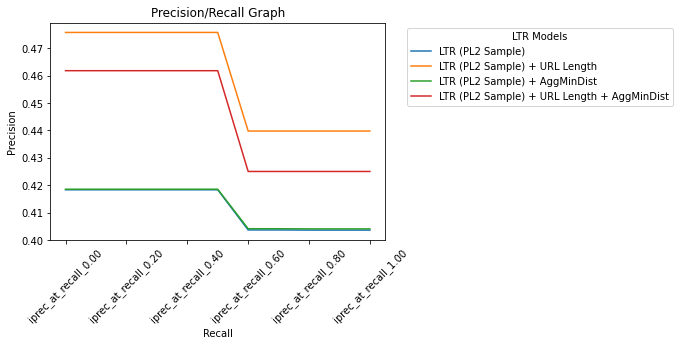

In [55]:
import matplotlib.pyplot as plt

# iprec_at_recall.set_index('name', inplace=True)
iprec_at_recall.T.plot(rot=45)
plt.legend(title='LTR Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Precision/Recall Graph")
plt.xlabel("Recall")
plt.ylabel("Precision")

# Improvement/Unaffected/Degredation

In [48]:
def affected_queries(model, model_display_name):
  evaluation_ltr_baseline = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics = ["map"],
    names = ["LTR (PL2 Sample)"],
    perquery = True)
  
  evaluation_with_feature = pt.Experiment(
    [model],
    test_topics,
    test_qrels,
    eval_metrics = ["map"],
    names = [model_display_name],
    perquery = True)
  
  affected = evaluation_ltr_baseline['value'] - evaluation_with_feature['value']
  affected.tolist()
  total = evaluation_ltr_baseline["name"].size
  negatively_affected = sum(i < 0 for i in affected)
  positively_affected = sum(i > 0 for i in affected)
  unaffected = total - (negatively_affected + positively_affected)
  print("Total Number of Queries", total)
  print("Number of Degraded Queries: ", negatively_affected)
  print("Number of Improved Queries: ", positively_affected)
  print("Unaffected Queries: ", unaffected)

In [51]:
affected_queries(boosted_model_url_slashes, "LTR (PL2 Sample) + URL Length")


Total Number of Queries 75
Number of Degraded Queries:  23
Number of Improved Queries:  27
Unaffected Queries:  25


In [52]:
affected_queries(boosted_model_dist, "LTR (PL2 Sample) + Agg MinDist")


Total Number of Queries 75
Number of Degraded Queries:  4
Number of Improved Queries:  7
Unaffected Queries:  64


In [53]:
affected_queries(model_5_features, "LTR (PL2 Sample) + URL Length + Agg MinDist")


Total Number of Queries 75
Number of Degraded Queries:  27
Number of Improved Queries:  17
Unaffected Queries:  31


In [57]:
print(np.array(test_topics["qid"]))

['6' '7' '9' '17' '29' '32' '35' '46' '49' '51' '52' '54' '59' '60' '64'
 '65' '67' '69' '75' '78' '80' '83' '84' '85' '86' '89' '92' '93' '94'
 '95' '98' '106' '108' '109' '110' '112' '113' '117' '118' '122' '123'
 '128' '129' '135' '140' '142' '143' '144' '145' '146' '149' '156' '158'
 '161' '162' '168' '171' '183' '184' '193' '195' '196' '199' '202' '203'
 '210' '211' '212' '213' '214' '215' '217' '218' '223' '224']


# Delta AP Graphs

In [60]:
def delta_ap_graph(model):
  evaluation_pl2 = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map"],
    names=["LTR (PL2 Sample)"],
    perquery=True)
  
  evaluation_feature = pt.Experiment(
    [model],
    test_topics,
    test_qrels,
    eval_metrics=["map"],
    names=["Model in Comparison"],
    perquery=True)
  
  values = evaluation_feature['value']
  evaluation_pl2 = evaluation_pl2.join(values, rsuffix='_with_feature')
  evaluation_pl2['delta_value'] = evaluation_pl2['value_with_feature'] - evaluation_pl2['value']
  evaluation_pl2[evaluation_pl2['delta_value'].abs() > 0.02]
  query_texts = np.array(test_topics["query"])
  query_qid = np.array(test_topics["qid"])

  qid_texts = []
  for each in range(0,len(query_texts)):
    qid_texts.append(query_qid[each] + ":" + query_texts[each])

  evaluation_pl2['qid_texts'] = qid_texts

  evaluation_pl2[evaluation_pl2['delta_value'].abs() > 0.02].sort_values('delta_value', 
                                                           ascending=False).plot.bar(x="qid_texts", 
                                                                                     y="delta_value", 
                                                                                     rot=90, 
                                                                                     title="delta-bar chart")
  return evaluation_pl2

,name,qid,measure,value,value_with_feature,delta_value,qid_texts
0,LTR (PL2 Sample),6,map,1.000000,0.333333,-0.666667,6:philadelphia streets
1,LTR (PL2 Sample),7,map,1.000000,0.142857,-0.857143,7:togo embassy
2,LTR (PL2 Sample),9,map,0.190909,0.611111,0.420202,9:baltimore
3,LTR (PL2 Sample),17,map,1.000000,1.000000,0.000000,17:secure linux
4,LTR (PL2 Sample),29,map,0.000000,0.000000,0.000000,29:grand canyon monitoring and research center
...,...,...,...,...,...,...,...
70,LTR (PL2 Sample),215,map,0.062500,0.500000,0.437500,215:nih video cast
71,LTR (PL2 Sample),217,map,1.000000,0.500000,-0.500000,217:astronaut biographies
72,LTR (PL2 Sample),218,map,0.100000,0.090909,-0.009091,218:medwatch
73,LTR (PL2 Sample),223,map,0.250000,0.333333,0.083333,223:wright brothers history


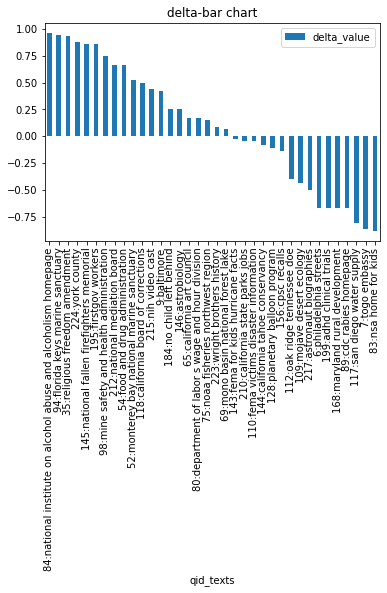

In [61]:
delta_ap_graph(boosted_model_url_slashes)

,name,qid,measure,value,value_with_feature,delta_value,qid_texts
0,LTR (PL2 Sample),6,map,1.000000,1.000000,0.000000,6:philadelphia streets
1,LTR (PL2 Sample),7,map,1.000000,1.000000,0.000000,7:togo embassy
2,LTR (PL2 Sample),9,map,0.190909,0.190909,0.000000,9:baltimore
3,LTR (PL2 Sample),17,map,1.000000,1.000000,0.000000,17:secure linux
4,LTR (PL2 Sample),29,map,0.000000,0.000000,0.000000,29:grand canyon monitoring and research center
...,...,...,...,...,...,...,...
70,LTR (PL2 Sample),215,map,0.062500,0.058824,-0.003676,215:nih video cast
71,LTR (PL2 Sample),217,map,1.000000,1.000000,0.000000,217:astronaut biographies
72,LTR (PL2 Sample),218,map,0.100000,0.100000,0.000000,218:medwatch
73,LTR (PL2 Sample),223,map,0.250000,0.250000,0.000000,223:wright brothers history


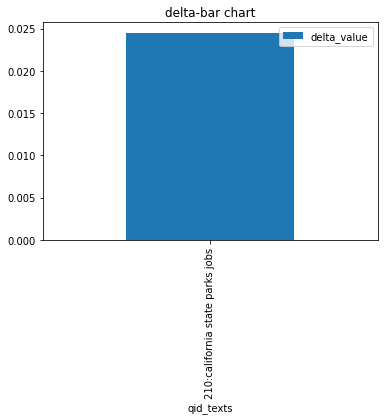

In [62]:
delta_ap_graph(boosted_model_dist)

,name,qid,measure,value,value_with_feature,delta_value,qid_texts
0,LTR (PL2 Sample),6,map,1.000000,0.333333,-0.666667,6:philadelphia streets
1,LTR (PL2 Sample),7,map,1.000000,0.142857,-0.857143,7:togo embassy
2,LTR (PL2 Sample),9,map,0.190909,0.625000,0.434091,9:baltimore
3,LTR (PL2 Sample),17,map,1.000000,1.000000,0.000000,17:secure linux
4,LTR (PL2 Sample),29,map,0.000000,0.000000,0.000000,29:grand canyon monitoring and research center
...,...,...,...,...,...,...,...
70,LTR (PL2 Sample),215,map,0.062500,0.500000,0.437500,215:nih video cast
71,LTR (PL2 Sample),217,map,1.000000,0.500000,-0.500000,217:astronaut biographies
72,LTR (PL2 Sample),218,map,0.100000,0.076923,-0.023077,218:medwatch
73,LTR (PL2 Sample),223,map,0.250000,1.000000,0.750000,223:wright brothers history


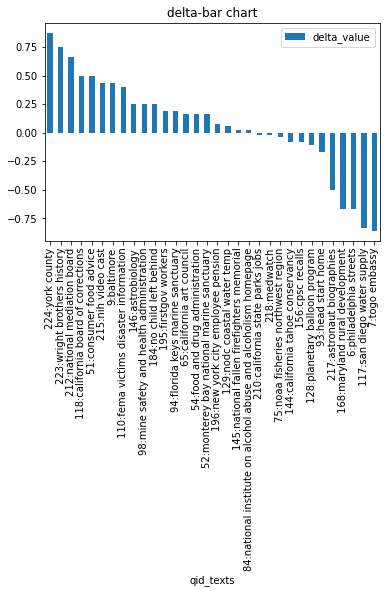

In [63]:
delta_ap_graph(model_5_features)

# That's all Folks

**Submission Instructions:** Complete this notebook. Please make your submission on the Moodle Exercise 2 submission instance. As part of your submission, you will need to hand-in the following:
- A **PDF report** (6 pages MAX) with your answers to questions Q1--Q6 of the specification
- Your **completed .ipynb Colab notbook** (use File... Download .ipynb).

Your PDF report along your ipynb notebook solution must be submitted by **Wednesday 24th March 2021, 4:30pm**.